# PCA on Tree‑Ring Chronologies

A notebook that:
1) loads your Excel sheet
2) selects the requested columns and years
3) standardizes the features
4) runs PCA
5) saves scores to Excel
6) plots explained variance

> **Requirements**: `pandas`, `numpy`, `scikit-learn`, `openpyxl`, `matplotlib`


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 120)

## 1) File paths and column list

In [3]:
excel_path = 'Data/upper-colorado-trees.xls'   # input file
sheet_name = 'standard chrons'                 # sheet with data
header_row = 1                                  # 0-based row index for header (Excel row 2)
year_min, year_max = 1490, 1998
n_components = 30                               # number of PCs to compute

# Column names (must match your file)
columns = ['YEAR','PIC','WIL','COL','PLU','MCP','SAR','UNA','ATR','PUM','RED','RIF','CAT','GMR','ENC','DOU','TRG','COD','MTR','PRP','NPU','SLK','EAG','BEN','RUS','JFU','FBN','DJM','NUR','RPC','WED']

## 2) Load data and basic filtering

In [4]:
# Read Excel and keep only the requested columns
df = pd.read_excel(excel_path, sheet_name=sheet_name, header=header_row)

# Simple column check, then select
missing = [c for c in columns if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns in the Excel sheet: {missing}")

df_sel = df[columns].copy()

# Keep rows within the target year range
mask = (df_sel['YEAR'] >= year_min) & (df_sel['YEAR'] <= year_max)
df_years = df_sel.loc[mask].copy()

# Set YEAR as index 
df_years = df_years.set_index('YEAR')

# Peek
df_years.head()

,PIC,WIL,COL,PLU,MCP,SAR,UNA,ATR,PUM,RED,RIF,CAT,GMR,ENC,DOU,TRG,COD,MTR,PRP,NPU,SLK,EAG,BEN,RUS,JFU,FBN,DJM,NUR,RPC,WED
YEAR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1490.0,0.843,0.982,1.088,1.223,1.043,2.611,1.102,1.873,1.344,1.646,1.081,2.077,2.003,1.253,1.006,1.319,1.896,1.790,1.462,0.888,0.813,1.126,1.546,0.896,1.520,0.925,1.389,1.426,1.3825,1.408
1491.0,1.018,1.435,1.459,1.217,1.286,3.258,1.537,2.140,1.344,1.669,1.177,2.326,1.845,1.263,1.555,1.391,1.809,1.751,1.492,1.071,0.726,1.483,2.148,1.157,1.823,1.167,1.190,1.473,1.6475,1.415
1492.0,1.018,0.892,1.356,1.091,1.265,2.766,0.803,1.783,1.406,1.541,1.150,1.089,1.604,1.291,1.370,1.087,2.055,1.412,1.553,1.151,0.540,1.237,1.510,1.234,1.787,1.268,1.111,1.330,0.9840,1.383
1493.0,0.751,0.993,0.978,0.876,1.197,1.137,0.990,1.311,1.210,1.108,1.014,0.592,0.972,0.732,1.252,1.157,1.388,0.794,0.623,0.906,0.621,1.110,1.122,0.942,1.785,2.332,1.183,0.926,1.1055,1.137
1494.0,0.939,1.206,1.225,1.466,1.337,2.096,1.093,1.953,1.382,1.518,1.194,2.299,1.319,1.035,1.469,1.665,1.655,1.024,1.127,1.119,1.025,1.041,1.672,1.033,1.969,1.776,1.157,1.067,1.4970,1.180


## 3) Standardize features and run PCA

In [5]:
# Standardize scalar
scaler = StandardScaler()
X_std = scaler.fit_transform(df_years.values)

# Fit PCA
pca = PCA(n_components=n_components)
scores_array = pca.fit_transform(X_std)   

# Build DataFrames for readability
pc_names = [f'PC {i+1}' for i in range(pca.n_components_)]
scores = pd.DataFrame(scores_array, index=df_years.index, columns=pc_names)        # scores (time series of PCs)
loadings = pd.DataFrame(pca.components_, index=pc_names, columns=df_years.columns) # component loadings
variance = pd.DataFrame({
    'explained_variance': pca.explained_variance_,
    'explained_variance_ratio': pca.explained_variance_ratio_,
    'singular_values': pca.singular_values_,
}, index=pc_names)

# Quick look
#variance.head(10).round(4)

## 4) Print explained variance 

In [6]:
with np.printoptions(precision=4, suppress=True):
    print('Explained variance per PC:')
    print(pca.explained_variance_)

Explained variance per PC:
[13.5267  2.4227  1.8394  1.5488  1.1206  0.8602  0.7961  0.7243  0.6467
  0.5624  0.531   0.5032  0.4534  0.4365  0.4001  0.3797  0.3433  0.3155
  0.3115  0.3072  0.2759  0.2739  0.2201  0.2129  0.2035  0.1919  0.1865
  0.1708  0.1501  0.144 ]


## 5) Save PCA scores to Excel

In [8]:
output_excel = 'pca_results.xlsx'

with pd.ExcelWriter(output_excel, engine='openpyxl') as writer:
    scores.to_excel(writer, sheet_name='Scores')
    loadings.to_excel(writer, sheet_name='Loadings')
    variance.to_excel(writer, sheet_name='Variance')

print(f'Saved PCA outputs to: {output_excel}')

Saved PCA outputs to: pca_results.xlsx


## 6) Plot explained variance and cumulative variance

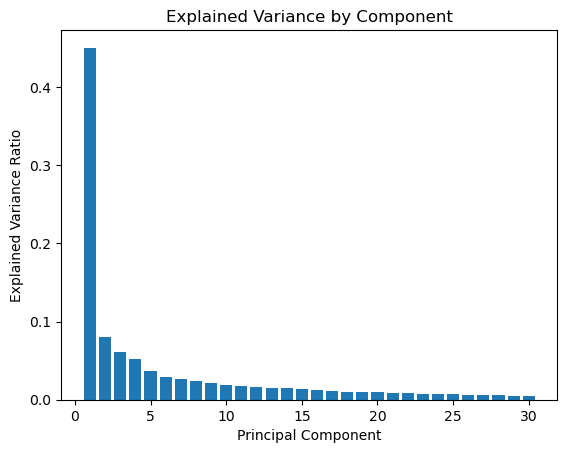

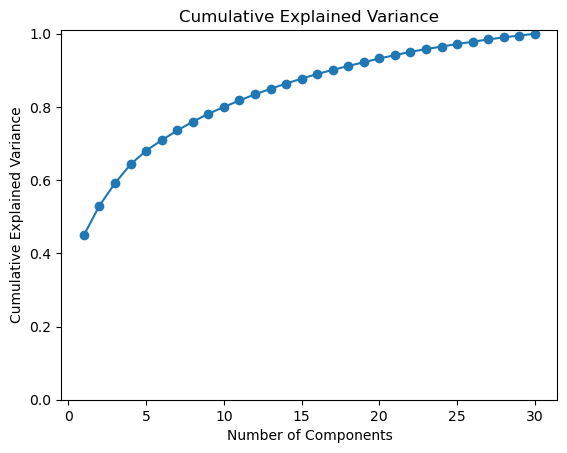

In [9]:
# Explained variance ratio (bar) – simple, no style/colors per instructions
plt.figure()
plt.bar(np.arange(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Component')
plt.show()

# Cumulative explained variance (line)
cum_var = np.cumsum(pca.explained_variance_ratio_)

plt.figure()
plt.plot(np.arange(1, len(cum_var) + 1), cum_var, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.ylim(0, 1.01)
plt.show()

In [10]:
cum_var

array([0.45000283, 0.53060065, 0.59179397, 0.64331783, 0.68059857,
       0.70921539, 0.73570143, 0.75979789, 0.78131364, 0.8000235 ,
       0.81768779, 0.83442941, 0.84951162, 0.86403462, 0.8773438 ,
       0.8899751 , 0.90139761, 0.91189268, 0.92225438, 0.93247394,
       0.9416535 , 0.95076608, 0.95808824, 0.96517221, 0.97194343,
       0.97832748, 0.98453181, 0.99021436, 0.99520816, 1.        ])